In [3]:
import sys
sys.path.insert(1, '/storage/home/nxt5197/work/530_stellar_atmospheres/lib/')
from statmospheres import log_integrator
from statmospheres import better_integrator
from statmospheres import ave
from scipy.special import wofz
from statmospheres import Planck_from_wavenumbers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../lib/plt_format.mplstyle')
from scipy.special import expn
from astropy import units as u
from astropy import constants as const

$H_\nu (\tau_\nu) = \frac{1}{4}F_\nu (\tau_\nu) \equiv \frac{1}{4}\Phi_{\tau_\nu}[S_\nu(t_\nu)] = \frac{1}{4\pi} \mathscr{F_\nu} (\tau_\nu)$ <br>
$\Phi_{0}[S_\nu(t_\nu)] = 2 \int_0^\infty S_\nu(t_\nu) E_2(t_\nu) dt_\nu$ <br>
$H_\nu (0) = \frac{1}{4} S_\nu \big( \tau_\nu = \frac{2}{3} \big)$ <br>
$\mathscr{F_\nu} (0) = 4 \pi H_\nu (0) = \pi S_\nu \big( \tau_\nu = \frac{2}{3} \big)$

In [4]:
def T_grey(Teff,tau):
    return Teff*(3*tau/4+0.5)**0.25

def B_grey(nu, Teff,tau):
    return (2 * const.h.cgs * nu**3 / (const.c.cgs)**2) / ((np.exp(const.h.cgs*nu/(const.k_B.cgs*T_grey(Teff,tau))))-1) / u.sr

In [5]:
Teff = 8700*u.K

t_min=-20
t_max=2
t_density=30
t_points = round(t_density*(t_max-t_min))
tau = 10**np.linspace(t_min,t_max,t_points)

x_min=10**-7
x_max=24
density=10**4
points = round(density*(x_max-x_min))
x=np.linspace(x_min,x_max,points)/u.micron
nu_array=(x*const.c).to(u.Hz)

In [6]:
# 9b Integrating over all tau at each wavenumber
Fv = [0 for i in range(len(nu_array))]
for i,nu in enumerate(nu_array):
    Fv[i] = 2*np.pi*log_integrator(tau,B_grey(nu,Teff,tau)*expn(2,tau))

# 9c Using the EB approximation
FvEB = np.pi * B_grey(nu_array,Teff,2/3)

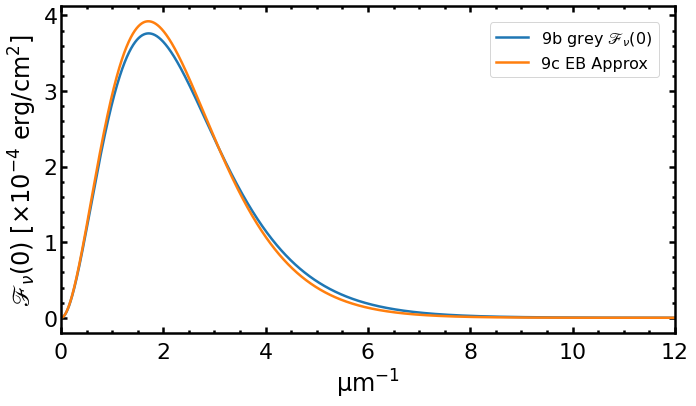

In [7]:
# 9d Plot Fv(0) vs wavenumber
from astropy.visualization import quantity_support
quantity_support()
plt.plot(x,[y.value/1e-4 for y in Fv],label=r'9b grey $\mathscr{F}_\nu(0)$')
plt.plot(x,[y.value/1e-4 for y in FvEB],label=f'9c EB Approx')
plt.xlim(0,12)
plt.ylabel(r'$\mathscr{F}_\nu(0)$ [$\times 10^{-4}$ erg/cm$^2$]')
plt.legend()
plt.show()

In [8]:
# 9e Integrating over all tau at each wavenumber
tau_array=np.linspace(0.9,1.1,1005) # Small range of tau around tau=1 is good enough

Sv = [[0 for i in range(len(nu_array))] for j in range(len(tau_array))]
dSvdt = [[0 for i in range(len(nu_array))] for j in range(len(tau_array)-1)]
d2Svdt2 = [[0 for i in range(len(nu_array))] for j in range(len(tau_array)-2)]

for t,tau in enumerate(tau_array):  
    Sv[t] = B_grey(nu_array,Teff,tau).value
    if t>0:
        dSvdt[t-1] = (Sv[t]-Sv[t-1])/(tau_array[t]-tau_array[t-1])
    if t>1:
        d2Svdt2[t-2] = (dSvdt[t-1]-dSvdt[t-2])/(tau_array[t-1]-tau_array[t-2])
print(f'Length of Tau array: {len(tau_array)}, Sv array: {len(Sv)}, dSv/dt array: {len(dSvdt)}, d^2Sv/dt^2 array: {len(d2Svdt2)}')
print(f'\tIndex of Tau = 1,')
print(f'\tafter cutting off the first two indices for differentials: {np.where(tau_array[2:]==1)[0][0]}')
print(f'And the full Tau array:')
tau_array

Length of Tau array: 1005, Sv array: 1005, dSv/dt array: 1004, d^2Sv/dt^2 array: 1003
	Index of Tau = 1,
	after cutting off the first two indices for differentials: 500
And the full Tau array:


array([0.9       , 0.9001992 , 0.90039841, ..., 1.09960159, 1.0998008 ,
       1.1       ])

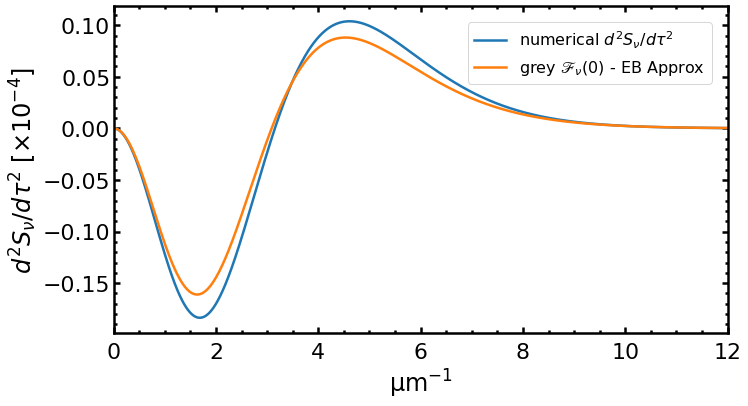

In [10]:
plt.plot(x,d2Svdt2[500]/1e-4,label=r'numerical $d^2S_\nu/d\tau^2$')
plt.plot(x,[(val.value-FvEB[y].value)/1e-4 for y,val in enumerate(Fv)],label=r'grey $\mathscr{F}_\nu(0)$ - EB Approx')
plt.xlim(0,12)
plt.ylabel(r'$d^2S_\nu/d\tau^2$ [$\times 10^{-4}$]')
plt.legend()
plt.show()